In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import itertools
import sklearn
import sklearn.datasets
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)
import plotly
plotly.offline.init_notebook_mode(connected=True)

import kliep
import knn

In [ ]:
entropy_ans = np.log(np.arange(0.1, 1, 0.1) * np.sqrt(2*np.pi*np.e))
entropy_pred = []
for sigma in np.arange(0.1, 1, 0.1):
    X = scipy.stats.norm(0, sigma).rvs(1000).reshape(-1, 1)
    entropy_pred += [knn.entropy_knn(X, k=10)]
    
plt.plot(entropy_ans)
plt.plot(entropy_pred)

In [ ]:
tmis = []
cmis_4h = []
cmis_knn3 = []
cmis_knn5 = []
cmis_knn15 = []
for c in tqdm.tqdm(np.arange(0, 1, 0.1)):
    pre = [[1,    c,    0],
           [c,    1, -0.4],
           [0, -0.4,    1]]
    cov = np.linalg.inv(pre)
    X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(200)
    tmis += [knn.cmi_gaussian(cov)[0][1]]

    x = X[:, [1]]
    y = X[:, [0]]
    z = X[:, (np.arange(3) != 0) & (np.arange(3) != 1)]
    cmis_4h += [knn.cmi_4h(x, y, z, k=10)]
    cmis_knn3 += [knn.cmi_knn(x, y, z, k=3)]
    cmis_knn5 += [knn.cmi_knn(x, y, z, k=5)]
    cmis_knn15 += [knn.cmi_knn(x, y, z, k=15)]

In [ ]:
plt.plot(np.arange(0, 1, 0.1), tmis, label='theoretical')
plt.plot(np.arange(0, 1, 0.1), cmis_4h, label='4h')
plt.plot(np.arange(0, 1, 0.1), cmis_knn3, label='knn3')
plt.plot(np.arange(0, 1, 0.1), cmis_knn5, label='knn5')
plt.plot(np.arange(0, 1, 0.1), cmis_knn15, label='knn15')
plt.legend()
# plt.savefig('output/plot-cmi-gaussian.pdf', format='pdf')

In [ ]:
pre = [[   1,  0.5,    0],
       [ 0.5,    1, -0.5],
       [   0, -0.5,    1]]
diag = np.sqrt(np.diag(np.linalg.inv(pre)))
pre = pre * diag.reshape(-1, 1) * diag.reshape(1, -1)
cov = np.linalg.inv(pre)

tmi = knn.cmi_gaussian(cov)[0][1]
methods = ['knn_4h', 'knn10']
errors = {method: {n: [] for n in np.arange(100, 1000, 100)} for method in methods}

for n in tqdm.tqdm(np.arange(100, 1000, 100)):
    for _ in range(100):
        X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(n)
        x = X[:, [1]]
        y = X[:, [0]]
        z = X[:, (np.arange(3) != 0) & (np.arange(3) != 1)]
        errors['knn_4h'][n] += [abs(knn.cmi_4h(x, y, z, k=10) - tmi)]
        errors['knn10'][n] += [abs(knn.cmi_knn(x, y, z, k=10) - tmi)]

In [ ]:
plt.boxplot(list(errors['knn_4h'].values()), positions=np.arange(9)-0.1, widths=0.2, showfliers=False)
plt.boxplot(list(errors['knn10'].values()), positions=np.arange(9)+0.1, widths=0.2, showfliers=False)
plt.xticks(np.arange(9), np.arange(100, 1000, 100))
plt.tight_layout()
# plt.hlines(tmi, -1, 9, color='red')
plt.savefig('output/box-gaussian-1.pdf', format='pdf')

In [ ]:
tmi = knn.cmi_gaussian(cov)[0][2]
methods = ['knn_4h', 'knn10']
errors = {method: {n: [] for n in np.arange(100, 1000, 100)} for method in methods}

for n in tqdm.tqdm(np.arange(100, 1000, 100)):
    for _ in range(100):
        X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(n)
        x = X[:, [2]]
        y = X[:, [0]]
        z = X[:, (np.arange(3) != 0) & (np.arange(3) != 2)]
#         errors['knn_4h'][n] += [max(knn.cmi_4h(x, y, z, k=10), 0)]
#         errors['knn10'][n] += [max(knn.cmi_knn(x, y, z, k=10), 0)]
        errors['knn_4h'][n] += [abs(knn.cmi_4h(x, y, z, k=10) - tmi)]
        errors['knn10'][n] += [abs(knn.cmi_knn(x, y, z, k=10) - tmi)]

In [ ]:
plt.boxplot(list(errors['knn_4h'].values()), positions=np.arange(9)-0.1, widths=0.2, showfliers=False)
plt.boxplot(list(errors['knn10'].values()), positions=np.arange(9)+0.1, widths=0.2, showfliers=False)
plt.xticks(np.arange(9), np.arange(100, 1000, 100))
plt.tight_layout()
# plt.hlines(0, -1, 9, color='red')
plt.savefig('output/box-gaussian-2.pdf', format='pdf')

In [12]:
def heat_mi(X, ks=[3, 5, 15]):
    m = len(ks)
    f, axes = plt.subplots(1, m, figsize=[3 * m + 1, 3])
    n, d = X.shape
    for l, k in enumerate(ks):
        mis = np.eye(d)
        for i, j in [(i, j) for i in range(d) for j in range(d) if i != j]:
            x = X[:, [i]]
            y = X[:, [j]]
            mis[i, j] = knn.mi_knn(x, y, k=3)

        mis[mis < 0] = 0
        mis[np.eye(d, dtype=bool)] = None
        sns.heatmap(mis, annot=True, ax=axes[l], center=0, cmap=palette, cbar=False)

def heat_cmi(X, ks=[3, 5, 15]):
    m = len(ks)
    f, axes = plt.subplots(1, m, figsize=[3 * m + 1, 3])
    n, d = X.shape
    for l, k in enumerate(ks):
        cmis = np.eye(d)
        for i, j in [(i, j) for i in range(d) for j in range(d) if i != j]:
            x = X[:, [i]]
            y = X[:, [j]]
            z = X[:, (np.arange(d) != i) & (np.arange(d) != j)]
            cmis[i, j] = knn.cmi_knn(x, y, z, k=k)

        cmis[cmis < 0] = 0
        cmis[np.eye(d, dtype=bool)] = None
        sns.heatmap(cmis, annot=True, ax=axes[l], center=0, cmap=palette, cbar=False)

## Gaussian mixture

In [ ]:
cluster = (np.arange(1000) < 500).astype(int)
X1 = scipy.stats.multivariate_normal(mean=[-4, 0], cov=np.eye(2)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[+4, 0], cov=np.eye(2)).rvs(500)
X = np.vstack([X1, X2])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X = np.hstack([X, cluster.reshape(-1, 1)])
X.shape

In [ ]:
sns.pairplot(pd.DataFrame(X), hue=2)
plt.savefig('output/pair-gaussian-1.pdf', format='pdf')

In [ ]:
heat_cmi(X)

In [ ]:
n, d = X.shape
edges, losses = knn.learn_mrf(X)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj = nx.adjacency_matrix(g).toarray()
f, axes = plt.subplots(1, 2, figsize=[6, 3])
sns.heatmap(adj, annot=True, center=0, ax=axes[0], cmap=palette, cbar=False)
plt.plot(losses, axes=axes[1])

## Gaussian mixture 2

In [ ]:
cluster = np.arange(1500)
cluster[cluster < 500] = 0
cluster[(cluster >= 500) & (cluster < 1000)] = 1
cluster[cluster >= 1000] = 2
X1 = scipy.stats.multivariate_normal(mean=[-8, 0], cov=np.eye(2)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[+8, 0], cov=np.eye(2)).rvs(500)
X3 = scipy.stats.multivariate_normal(mean=[ 0, 10], cov=np.eye(2)).rvs(500)
X = np.vstack([X1, X2, X3])
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X = np.hstack([X, cluster.reshape(-1, 1)])
X.shape

In [ ]:
sns.pairplot(pd.DataFrame(X), hue=2)
plt.savefig('output/pair-gaussian-2.pdf', format='pdf')

In [ ]:
heat_mi(X)
heat_cmi(X)

In [ ]:
n, d = X.shape
edges, losses = knn.learn_mrf(X)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj = nx.adjacency_matrix(g).toarray()
f, axes = plt.subplots(1, 2, figsize=[6, 3])
sns.heatmap(adj, annot=True, center=0, ax=axes[0], cmap=palette, cbar=False)
plt.plot(losses, axes=axes[1])

In [ ]:
methods = ['knn_4h', 'knn10']
errors = {method: {n: [] for n in np.arange(100, 1000, 100)} for method in methods}

for n in tqdm.tqdm(np.arange(100, 1000, 100)):
    for _ in range(100):
        cluster = np.arange(n)
        n1 = int(n / 3)
        n2 = 2 * int(n / 3) - n1
        cluster[cluster < n1] = 0
        cluster[(cluster >= n1) & (cluster < n2 + n1)] = 1
        cluster[cluster >= n2 + n1] = 2
        X1 = scipy.stats.multivariate_normal(mean=[-8, 0], cov=np.eye(2)).rvs(n1)
        X2 = scipy.stats.multivariate_normal(mean=[+8, 0], cov=np.eye(2)).rvs(n2)
        X3 = scipy.stats.multivariate_normal(mean=[ 0, 10], cov=np.eye(2)).rvs(n - n1 - n2)
        X = np.vstack([X1, X2, X3])
        X = np.hstack([X, cluster.reshape(-1, 1)])
        x = X[:, [1]]
        y = X[:, [2]]
        z = X[:, (np.arange(3) != 1) & (np.arange(3) != 2)]
        errors['knn_4h'][n] += [abs(knn.cmi_4h(x, y, z, k=10))]
        errors['knn10'][n] += [abs(knn.cmi_knn(x, y, z, k=10))]

In [ ]:
# plt.boxplot(list(errors['knn_4h'].values()), positions=np.arange(9)-0.1, widths=0.2, showfliers=False)
plt.boxplot(list(errors['knn10'].values()), positions=np.arange(9)+0.1, widths=0.2, showfliers=False)
plt.xticks(np.arange(9), np.arange(100, 1000, 100))
plt.tight_layout()
plt.savefig('output/box-gaussian-3.pdf', format='pdf')

# XOR

In [ ]:
cluster = (np.arange(2000) < 1000).astype(int)
X1 = scipy.stats.multivariate_normal(mean=[0, 8], cov=np.eye(2)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[8, 0], cov=np.eye(2)).rvs(500)
X3 = scipy.stats.multivariate_normal(mean=[8, 8], cov=np.eye(2)).rvs(500)
X4 = scipy.stats.multivariate_normal(mean=[0, 0], cov=np.eye(2)).rvs(500)
X = np.vstack([X1, X2, X3, X4])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X = np.hstack([X, cluster.reshape(-1, 1)])
X.shape

In [ ]:
sns.pairplot(pd.DataFrame(X), hue=2)
plt.savefig('output/pair-gaussian-3.pdf', format='pdf')

In [ ]:
heat_mi(X)
heat_cmi(X)

In [ ]:
n, d = X.shape
edges, losses = knn.learn_mrf(X)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj = nx.adjacency_matrix(g).toarray()
f, axes = plt.subplots(1, 2, figsize=[6, 3])
sns.heatmap(adj, annot=True, center=0, ax=axes[0], cmap=palette, cbar=False)
plt.plot(losses, axes=axes[1])

## iris

In [21]:
data = sklearn.datasets.load_iris()
df = pd.DataFrame(data['data'], columns=list(data.feature_names))
df['class'] = data.target
df[:5]
X = df.values

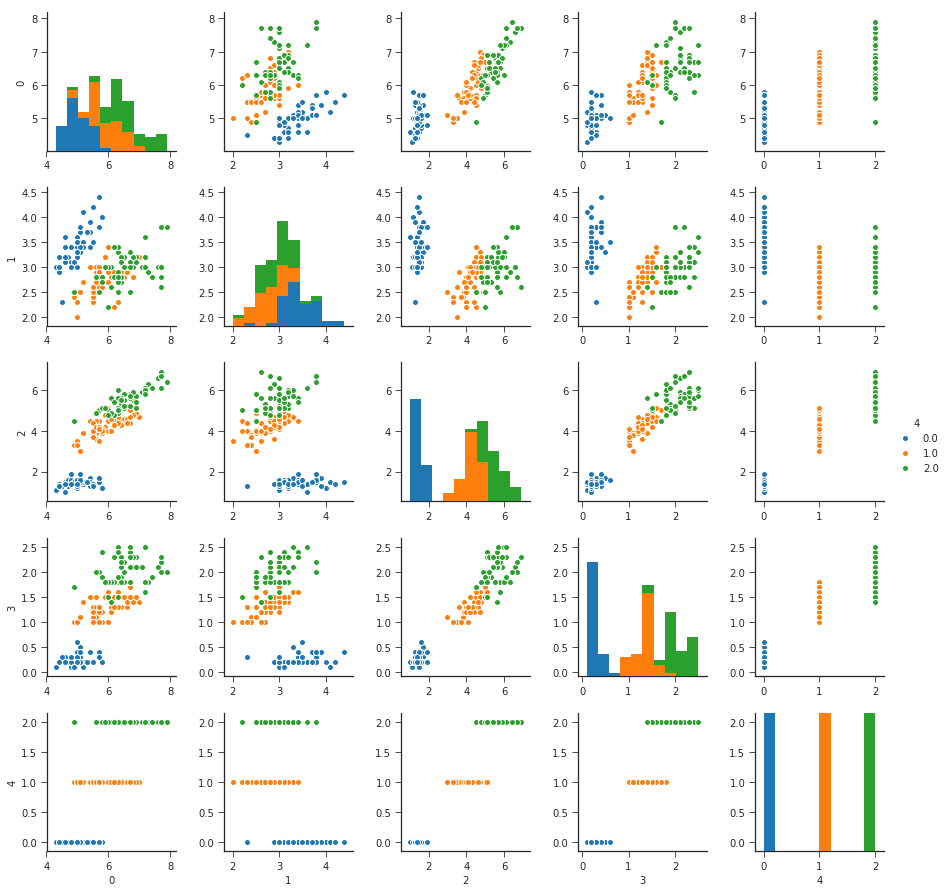

In [7]:
sns.pairplot(pd.DataFrame(X), hue=4)
plt.savefig('output/pair-iris.pdf', format='pdf')

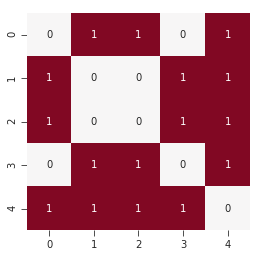

In [22]:
n, d = X.shape
edges = knn.learn_mrf(X)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj = nx.adjacency_matrix(g).toarray()
plt.figure(figsize=[4, 4])
sns.heatmap(adj, annot=True, center=0, cmap=palette, cbar=False)

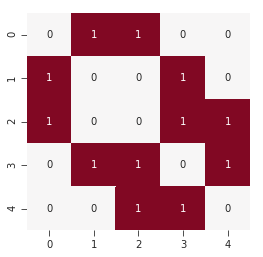

In [4]:
n, d = X.shape
edges = knn.learn_mrf(X, alpha=0.1)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj = nx.adjacency_matrix(g).toarray()
plt.figure(figsize=[4, 4])
sns.heatmap(adj, annot=True, center=0, cmap=palette, cbar=False)

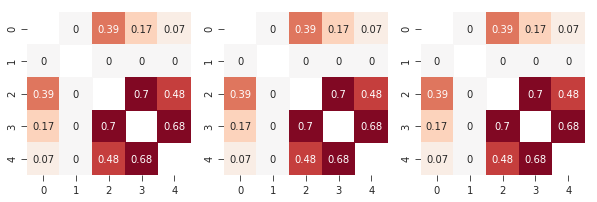

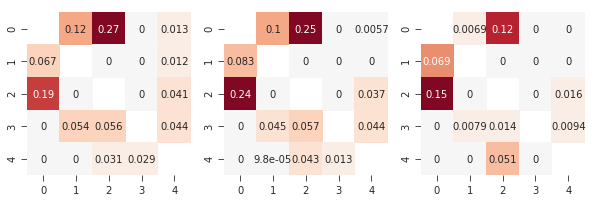

In [13]:
heat_mi(X)
heat_cmi(X)

## Boston

In [14]:
data = sklearn.datasets.load_boston()
df = pd.DataFrame(data['data'], columns=list(data.feature_names))
df['class'] = data.target
X = df.values
print(len(X))
df[:5]

506


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,class
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


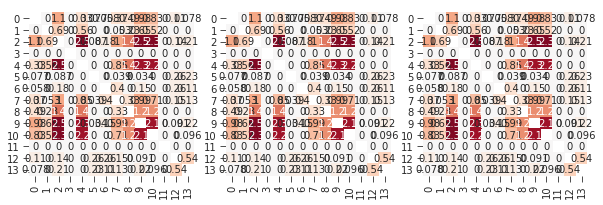

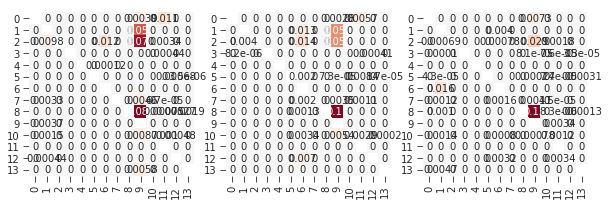

In [15]:
heat_mi(X)
heat_cmi(X)

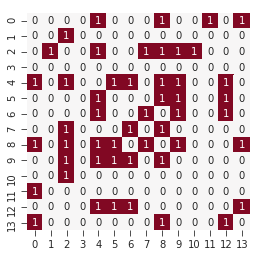

In [16]:
n, d = X.shape
edges = knn.learn_mrf(X)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj = nx.adjacency_matrix(g).toarray()
plt.figure(figsize=[4, 4])
sns.heatmap(adj, annot=True, center=0, cmap=palette, cbar=False)

/home/ytakashina/anaconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning:

The is_string_like function was deprecated in version 2.1.

/home/ytakashina/anaconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning:

The is_string_like function was deprecated in version 2.1.

/home/ytakashina/anaconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning:

The is_string_like function was deprecated in version 2.1.



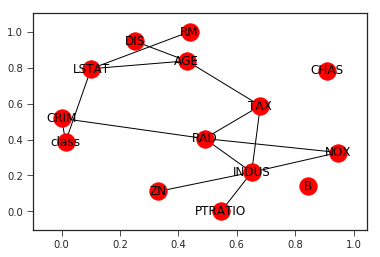

In [18]:
labels = dict(enumerate(list(data.feature_names) + ['class']))
nx.draw_networkx(g, labels=labels)

In [19]:
data.feature_names[g.neighbors(13)]

array(['LSTAT', 'CRIM'],
      dtype='<U7')